In [ ]:
!pip install yfinance

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
start = '2012-01-01'
end = '2023-10-21'
stock = 'GOOG'

data = yf.download(stock, start, end)

[*********************100%%**********************]  1 of 1 completed


In [3]:
data.reset_index(inplace=True)

In [4]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,16.262545,16.641375,16.248346,16.573130,16.573130,147611217
1,2012-01-04,16.563665,16.693678,16.453827,16.644611,16.644611,114989399
2,2012-01-05,16.491436,16.537264,16.344486,16.413727,16.413727,131808205
3,2012-01-06,16.417213,16.438385,16.184088,16.189817,16.189817,108119746
4,2012-01-09,16.102144,16.114599,15.472754,15.503389,15.503389,233776981
...,...,...,...,...,...,...,...
2965,2023-10-16,139.729996,140.904999,139.320007,140.490005,140.490005,17345600
2966,2023-10-17,140.029999,141.250000,138.529007,140.990005,140.990005,17424000
2967,2023-10-18,140.750000,141.990005,138.705002,139.279999,139.279999,18304900
2968,2023-10-19,139.800003,141.005005,138.600006,138.979996,138.979996,21831200


In [5]:
ma_100_days = data.Close.rolling(100).mean()

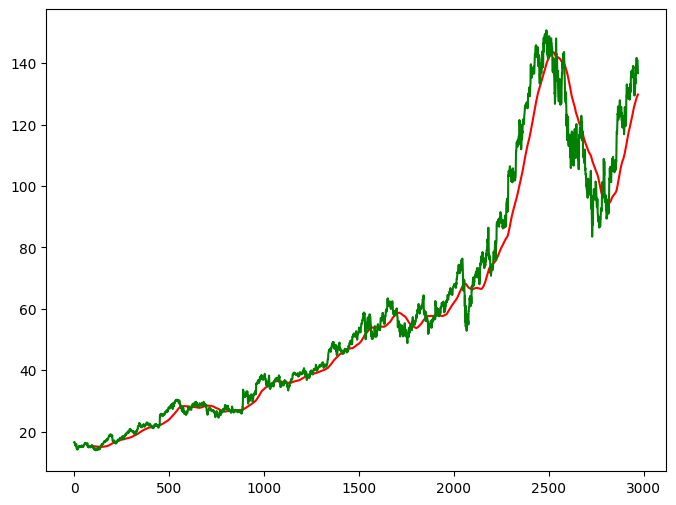

In [6]:
plt.figure(figsize=(8,6))
plt.plot(ma_100_days, 'r')
plt.plot(data.Close, 'g')
plt.show()

In [7]:
ma_200_days = data.Close.rolling(200).mean()

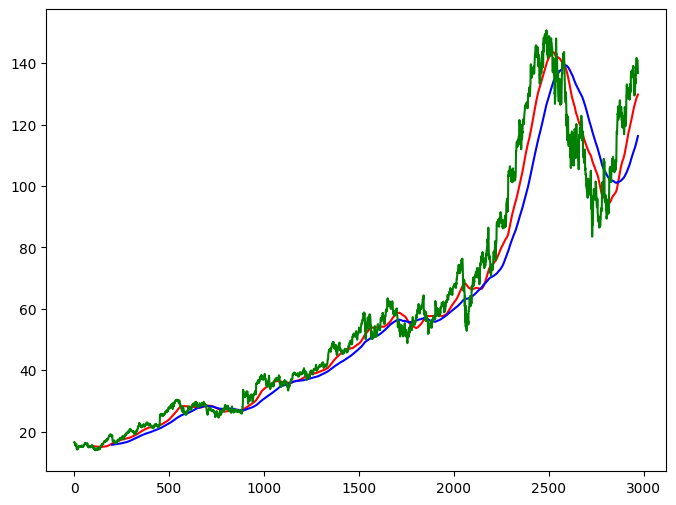

In [8]:
plt.figure(figsize=(8,6))
plt.plot(ma_100_days, 'r')
plt.plot(ma_200_days,'b')
plt.plot(data.Close,'g')
plt.show()

In [9]:
data.dropna(inplace=True)

In [10]:
data_train = pd.DataFrame(data.Close[0: int(len(data)*0.80)])
data_test = pd.DataFrame(data.Close[int(len(data)*0.80): len(data)])

In [11]:
data_train.shape[0]

2376

In [12]:
data_test.shape[0]

594

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [14]:
data_train_scale = scaler.fit_transform(data_train)

In [15]:
x = []
y = []

for i in range(100, data_train_scale.shape[0]):
    x.append(data_train_scale[i-100:i])
    y.append(data_train_scale[i,0])
    

In [16]:
x, y = np.array(x), np.array(y)

In [17]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [18]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True,
               input_shape = ((x.shape[1],1))))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation='relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units =1))

In [19]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [20]:
model.fit(x,y, epochs = 5, batch_size =32, verbose =1)

Epoch 1/5
72/72 [==============================] - 34s 320ms/step - loss: 0.0161
Epoch 2/5
72/72 [==============================] - 22s 304ms/step - loss: 0.0041
Epoch 3/5
72/72 [==============================] - 22s 301ms/step - loss: 0.0040
Epoch 4/5
72/72 [==============================] - 22s 299ms/step - loss: 0.0035
Epoch 5/5
72/72 [==============================] - 21s 298ms/step - loss: 0.0034


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [22]:
pas_100_days = data_train.tail(100)

In [23]:
data_test = pd.concat([pas_100_days, data_test], ignore_index=True)

In [24]:
data_test_scale  =  scaler.fit_transform(data_test)

In [25]:
x = []
y = []

for i in range(100, data_test_scale.shape[0]):
    x.append(data_test_scale[i-100:i])
    y.append(data_test_scale[i,0])
x, y = np.array(x), np.array(y)

In [26]:
y_predict = model.predict(x)

19/19 [==============================] - 3s 101ms/step


In [27]:
scale =1/scaler.scale_

In [28]:
y_predict = y_predict*scale

In [29]:
y = y*scale

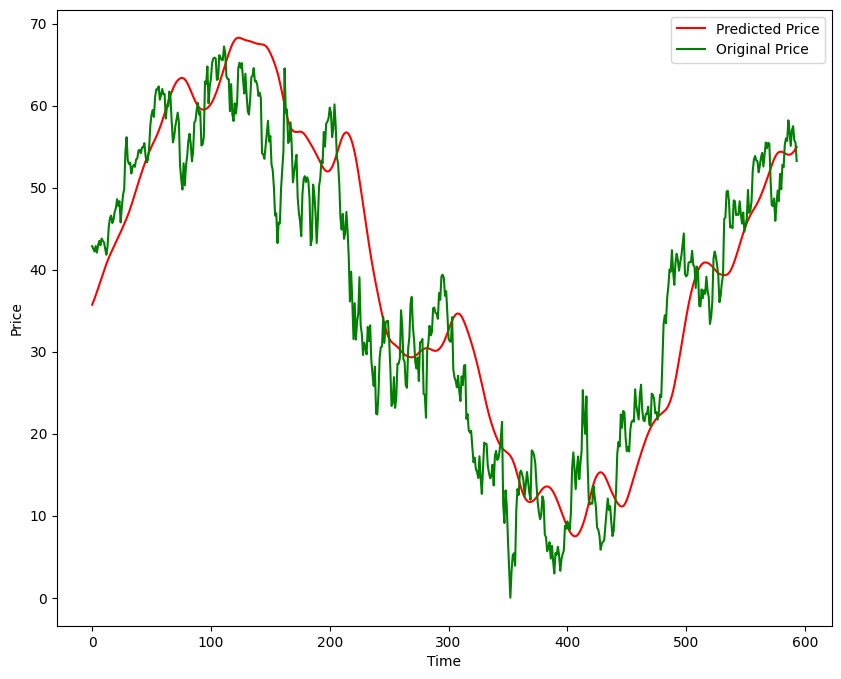

In [30]:
plt.figure(figsize=(10,8))
plt.plot(y_predict, 'r', label = 'Predicted Price')
plt.plot(y, 'g', label = 'Original Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
model.save('Stock Predictions Model.keras')